In [ ]:
!nvidia-smi

Sat Dec 26 14:19:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/AOI') #切換該目錄
os.listdir() #確認目錄內容

['test_images.zip',
 'classify',
 'Transfer_Training_Report.ipynb',
 'Transfer_Training_models',
 'Model.h5',
 'Transfer_Training.h5',
 'Transfer_Training.ipynb',
 'Dir_info.ipynb',
 'test_image_before',
 'test_images.zip (Unzipped Files)',
 'Model.ipynb']

In [ ]:
import numpy as np
import keras


# define Model

In [ ]:
# input 為 灰階 256 * 256 圖像
# 灰階 為 1 通道
input_shape = (256, 256, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv2D,MaxPooling2D,Flatten

def CNN_Onehot():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(6,activation='softmax'))
    model.summary()

    return model

# data

In [ ]:
# 將輸入圖片擴張
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split = 0.2
)


In [ ]:
# 產生迭代器
img_itr_train = train_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

img_itr_valid = train_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 4047 images belonging to 6 classes.
Found 1009 images belonging to 6 classes.


# Training

In [ ]:
model = CNN_Onehot()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
import math

# 計算幾個批次為一次學習
batch_size = 64
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_valid.samples/batch_size
)

In [ ]:
history = model.fit_generator(
    img_itr_train,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=img_itr_valid,
    validation_steps=validation_steps
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
64/64 [==============================] - 372s 6s/step - loss: 7.2713 - accuracy: 0.3462 - val_loss: 1.0547 - val_accuracy: 0.5977
Epoch 2/50
64/64 [==============================] - 291s 5s/step - loss: 0.8094 - accuracy: 0.7059 - val_loss: 1.0011 - val_accuracy: 0.7031
Epoch 3/50
64/64 [==============================] - 216s 3s/step - loss: 0.6440 - accuracy: 0.7852 - val_loss: 1.0750 - val_accuracy: 0.6641
Epoch 4/50
64/64 [==============================] - 164s 3s/step - loss: 0.6092 - accuracy: 0.8171 - val_loss: 0.6508 - val_accuracy: 0.7695
Epoch 5/50
64/64 [==============================] - 124s 2s/step - loss: 0.5658 - accuracy: 0.8191 - val_loss: 0.7629 - val_accuracy: 0.7578
Epoch 6/50
64/64 [==============================] - 101s 2s/step - loss: 0.4454 - accuracy: 0.8588 - val_loss: 0.5577 - val_accuracy: 0.8203
Epoch 7/50
64/64 [==============================] - 74s 1s/step - loss: 0.3872 - accuracy: 0.8633 - val_loss: 0.6945 - val_accuracy: 0.8008
Epoch 8/50
64/

In [ ]:
model.save('Model.h5')

from google.colab import files
# files.download('Model.h5')

# Review

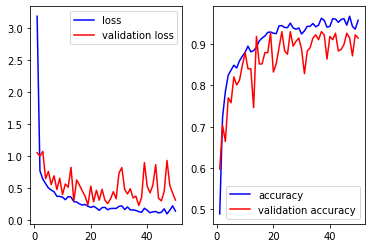

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['accuracy']
epochs = range(1, len(loss)+1)
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, loss, 'b', label='loss')
ax[0].plot(epochs, val_loss, 'r', label='validation loss')
ax[0].legend()
ax[1].plot(epochs, acc, 'b', label='accuracy')
ax[1].plot(epochs, val_acc, 'r', label='validation accuracy')
ax[1].legend()
plt.show()

# Valid

In [ ]:
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

evaluate_itr = valid_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = model.evaluate_generator(evaluate_itr)
print(f'loss = {loss:.2f}')
print(f'accuracy = {accuracy:.2f}')

Found 5056 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss = 0.24
accuracy = 0.95


In [ ]:
import numpy as np

labels = evaluate_itr.class_indices #查看类别的label

# 然后直接用predice_geneorator 可以进行预测
evaluate_itr.reset()
pred = model.predict_generator(evaluate_itr, verbose=1)

# 输出每个图像的预测类别
predicted_class_indices = np.argmax(pred, axis=1)
# 测试集的真实类别
true_label= evaluate_itr.classes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


316/316 [==============================] - 19s 60ms/step


In [ ]:
#使用pd.crosstab来简单画出混淆矩阵
import pandas as pd

table=pd.crosstab(predicted_class_indices,true_label,colnames=['predict'],rownames=['label'])
table

predict,0,1,2,3,4,5
label,,,,,,
0,1265,27,14,34,5,5
1,0,922,0,3,0,2
2,0,5,186,0,0,0
3,83,20,0,707,8,0
4,0,0,0,12,467,1
5,0,10,0,0,0,1280


# Prediction